In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('Father Genome.csv')
df.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_10944\3394823264.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Father Genome.csv')


,# rsid,chromosome,position,genotype
0,rs12564807,1,734462,AA
1,rs3131972,1,752721,AG
2,rs148828841,1,760998,AC
3,rs12124819,1,776546,AA
4,rs115093905,1,787173,GG


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601802 entries, 0 to 601801
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   # rsid      601802 non-null  object
 1   chromosome  601802 non-null  object
 2   position    601802 non-null  int64 
 3   genotype    601802 non-null  object
dtypes: int64(1), object(3)
memory usage: 18.4+ MB


In [3]:
# Standardize column names
df.columns = df.columns.str.strip().str.lower()

# Filter for Chromosome 22 only
df_subset = df[df['chromosome'].astype(str) == '22'].copy()

# Sort data by position (Crucial for HMM sequence)
df_subset = df_subset.sort_values(by='position')

print(f"Samples in Chromosome 22 (Before Cleaning): {len(df_subset)}")

# Filter: Keep only genotypes with length 2
df_clean = df_subset[df_subset['genotype'].str.len() == 2]

# Filter: Remove genotypes containing '-'
df_clean = df_clean[~df_clean['genotype'].str.contains('-')]

# Display initial cleaning results
print(f"Sample Count (After initial cleaning): {len(df_clean)}")
print("First 5 clean samples:")
print(df_clean[['position', 'genotype']].head())

# Check for unique symbols before final filtering
print("Current unique symbols:", df_clean['genotype'].unique())

# Remove specific outliers (II, DD)
df_clean = df_clean[~df_clean['genotype'].isin(['II', 'DD'])]

# Final check
print("Symbols after removing outliers:", df_clean['genotype'].unique())
print(f"Final Count (Ready for Model): {len(df_clean)}")

Samples in Chromosome 22 (Before Cleaning): 9096
Sample Count (After initial cleaning): 8995
First 5 clean samples:
        position genotype
565831  16055122       GG
565833  16504399       TT
565834  16855618       AG
565835  16872547       CC
565836  16888577       GG
Current unique symbols: ['GG' 'TT' 'AG' 'CC' 'AC' 'CT' 'AA' 'GT' 'CG' 'AT' 'II' 'DD']
Symbols after removing outliers: ['GG' 'TT' 'AG' 'CC' 'AC' 'CT' 'AA' 'GT' 'CG' 'AT']
Final Count (Ready for Model): 8889


In [4]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Encode genotypes: Convert text labels (e.g., 'AA', 'GG') to integers (0, 1, 2...)
obs_encoded = encoder.fit_transform(df_clean['genotype'])

# Reshape data: Convert to a column vector (N, 1) as required for matrix operations
obs_ready = obs_encoded.reshape(-1, 1)

# Display Encoding Results
print("1. Encoding Successful!")
print(f"   Final Data Shape: {obs_ready.shape}")

# Create and display the mapping dictionary (Symbol -> Integer ID)
mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print("\n2. Encoding Map (Symbol -> Integer):")
print(mapping)

# Verify the first 10 samples
print("\n3. First 10 Encoded Samples:")
print(obs_ready[:10].flatten())

1. Encoding Successful!
   Final Data Shape: (8889, 1)

2. Encoding Map (Symbol -> Integer):
{'AA': 0, 'AC': 1, 'AG': 2, 'AT': 3, 'CC': 4, 'CG': 5, 'CT': 6, 'GG': 7, 'GT': 8, 'TT': 9}

3. First 10 Encoded Samples:
[7 9 2 4 7 9 4 9 9 7]


In [9]:
!pip install hmmlearn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from hmmlearn import hmm
import pandas as pd

# 1. Define the HMM Model
# n_components=2: Assuming 2 hidden states (e.g., Stable vs. Transient)
# n_iter=100: Maximum iterations for the Baum-Welch algorithm
model = hmm.CategoricalHMM(n_components=2, n_iter=100, random_state=42)

print("1. Training HMM using Baum-Welch algorithm...")

# 2. Train the Model (Fit)
# This runs the EM algorithm to estimate A, B, and Pi
model.fit(obs_ready)

# Check for convergence
if model.monitor_.converged:
    print(f"   Training converged successfully after {model.monitor_.iter} iterations!\n")
else:
    print("   Warning: Model did not converge. Consider increasing n_iter.\n")

# 3. Display Results
print("--- Project Results (Library Implementation) ---\n")

# A) Initial Probabilities (Pi)
pi = model.startprob_
print(f"(Pi) Initial Probabilities:\n{pi.round(4)}\n")

# B) Transition Matrix (A)
states = ["State 0", "State 1"]
a_df = pd.DataFrame(model.transmat_, index=states, columns=states)
print(f"(A) Transition Matrix:\n{a_df.round(4)}\n")

# C) Emission Matrix (B)
b_df = pd.DataFrame(model.emissionprob_, 
                    index=states, 
                    columns=encoder.classes_)

print("(B) Emission Matrix:")
print(b_df.round(4).T)

1. Training HMM using Baum-Welch algorithm...
   Training converged successfully after 68 iterations!

--- Project Results (Library Implementation) ---

(Pi) Initial Probabilities:
[0.9989 0.0011]

(A) Transition Matrix:
         State 0  State 1
State 0   0.8793   0.1207
State 1   0.9956   0.0044

(B) Emission Matrix:
    State 0  State 1
AA   0.1584   0.0427
AC   0.0255   0.0085
AG   0.1304   0.0722
AT   0.0000   0.0051
CC   0.1978   0.3252
CG   0.0027   0.0025
CT   0.1065   0.2163
GG   0.2155   0.1939
GT   0.0241   0.0031
TT   0.1391   0.1305


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) 

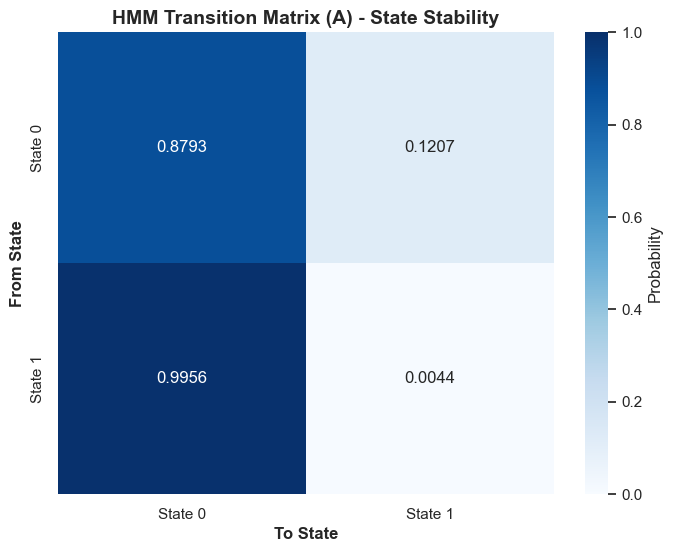

In [ ]:

plt.figure(figsize=(8, 6))
plt.title("HMM Transition Matrix (A) - State Stability", fontsize=14, fontweight='bold')

sns.heatmap(a_df, 
            annot=True,     
            fmt=".4f",       
            cmap="Blues",    
            vmin=0, vmax=1, 
            cbar_kws={'label': 'Probability'}) 

plt.ylabel('From State', fontweight='bold')
plt.xlabel('To State', fontweight='bold')
plt.show()

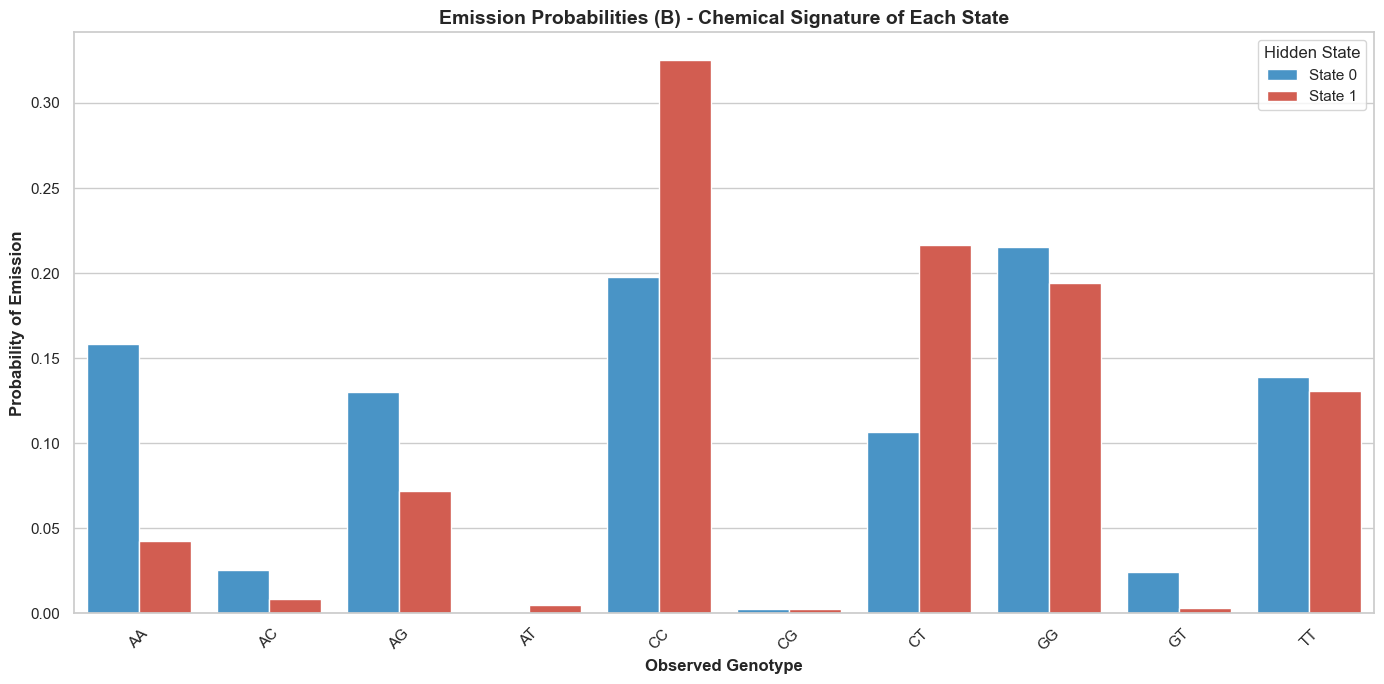

In [ ]:

b_df_plottable = b_df.reset_index().melt(id_vars='index', var_name='Genotype', value_name='Probability')
b_df_plottable.rename(columns={'index': 'Hidden State'}, inplace=True)

plt.figure(figsize=(14, 7))
plt.title("Emission Probabilities (B) - Chemical Signature of Each State", fontsize=14, fontweight='bold')

sns.barplot(data=b_df_plottable, 
            x='Genotype', 
            y='Probability', 
            hue='Hidden State',
            palette=["#3498db", "#e74c3c"]) 

plt.xlabel('Observed Genotype', fontweight='bold')
plt.ylabel('Probability of Emission', fontweight='bold')
plt.legend(title='Hidden State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------

Manual HMM

In [5]:
import numpy as np

# 1. Setup Data Dimensions
observations = obs_ready.flatten()
T = len(observations)  # Sequence length
N = 2                  # Number of Hidden States
M = 10                 # Number of Observation Symbols

print(f"Start: T={T}, N={N}, M={M}")

# 2. Function to initialize random normalized matrices
def initialize_parameters(N, M):
    # Initial Probabilities (Pi)
    pi = np.random.rand(N)
    pi = pi / np.sum(pi)
    
    # Transition Matrix (A) - (N x N)
    a = np.random.rand(N, N)
    # Normalize rows to sum to 1
    a = a / np.sum(a, axis=1, keepdims=True)
    
    # Emission Matrix (B) - (N x M)
    b = np.random.rand(N, M)
    # Normalize rows to sum to 1
    b = b / np.sum(b, axis=1, keepdims=True)
    
    return pi, a, b

# Execute Initialization
pi, a, b = initialize_parameters(N, M)

print('pi   ', pi)
print(' ----------')
print('a    ', a)
print(' ----------')
print('b    ', b)

Start: T=8889, N=2, M=10
pi    [0.07871205 0.92128795]
 ----------
a     [[0.73176961 0.26823039]
 [0.43821489 0.56178511]]
 ----------
b     [[0.21671863 0.16684298 0.04107269 0.11078544 0.12859183 0.03873636
  0.07336842 0.14853984 0.0354873  0.03985651]
 [0.13228188 0.07736029 0.01470011 0.15128986 0.01831903 0.18517466
  0.07257173 0.1608063  0.0244358  0.16306036]]


In [6]:
# --- Step 2: Scaled Forward Algorithm ---

def forward_scaled(obs, pi, a, b):
    T = len(obs)
    N = a.shape[0]
    alpha = np.zeros((T, N))
    c = np.zeros(T) # Scaling factors array
    
    # 1. Initialization (t=0)
    alpha[0] = pi * b[:, obs[0]]
    
    # Scaling step: Normalize alpha[0] to sum to 1
    c[0] = 1.0 / (np.sum(alpha[0]) + 1e-300)
    alpha[0] *= c[0]
    
    # 2. Induction
    for t in range(1, T):
        for j in range(N):
            # Standard forward probability calculation
            alpha[t, j] = np.sum(alpha[t-1] * a[:, j]) * b[j, obs[t]]
        
        # Scaling step at time t
        c[t] = 1.0 / (np.sum(alpha[t]) + 1e-300)
        alpha[t] *= c[t]
        
    return alpha, c

print("2. Scaled Forward function defined.")

# Test the function
alpha, c = forward_scaled(observations, pi, a, b)
print("--- Scaled Forward Alpha calculated ---")
print("Alpha shape:", alpha.shape)
print("Scaling factors (c) shape:", c.shape)
print("First 5 Alpha values:\n", np.round(alpha[:5], 4))

2. Scaled Forward function defined.
--- Scaled Forward Alpha calculated ---
Alpha shape: (8889, 2)
Scaling factors (c) shape: (8889,)
First 5 Alpha values:
 [[0.0731 0.9269]
 [0.1722 0.8278]
 [0.7276 0.2724]
 [0.9293 0.0707]
 [0.6944 0.3056]]


In [7]:
# --- Step 3: Scaled Backward Algorithm ---

def backward_scaled(obs, a, b, c):
    # Note: Requires scaling factors 'c' computed in the forward pass
    T = len(obs)
    N = a.shape[0]
    beta = np.zeros((T, N))
    
    # 1. Initialization (t=T-1)
    # Initialize with the last scaling factor
    beta[T-1] = 1.0 * c[T-1]
    
    # 2. Induction (Backwards from T-2 to 0)
    for t in range(T-2, -1, -1):
        for i in range(N):
            # Calculate sum of (Transition * Emission * Next Beta)
            beta[t, i] = np.sum(a[i, :] * b[:, obs[t+1]] * beta[t+1, :])
        
        # Scaling step
        # Multiply by the corresponding scaling factor from the forward pass
        beta[t] *= c[t]
            
    return beta

print("3. Scaled Backward function defined.")

# Test the function (Ensure forward_scaled has been run to get 'c')
beta = backward_scaled(observations, a, b, c)

print("--- Scaled Backward Beta calculated ---")
print("Beta shape:", beta.shape)
print("First 10 Beta values:\n", np.round(beta[:10], 4))

3. Scaled Backward function defined.
--- Scaled Backward Beta calculated ---
Beta shape: (8889, 2)
First 10 Beta values:
 [[ 4.6389  6.3839]
 [12.2098  8.8112]
 [39.6837 27.0612]
 [10.9888 12.3775]
 [ 5.9021  8.1052]
 [14.8397 10.6271]
 [12.2016 19.8834]
 [ 9.9483 14.7101]
 [10.8127 10.3022]
 [ 7.289   5.6949]]


In [8]:
# --- Step 3: Scaled E-Step (Expectation) ---

def e_step_scaled(alpha, beta, a, b, obs):
    T = len(obs)
    N = a.shape[0]
    
    # 1. Calculate Gamma (State probability at time t)
    # Using scaled Alpha and Beta prevents underflow
    gamma = alpha * beta
    # Normalize with epsilon to avoid division by zero
    gamma /= np.sum(gamma, axis=1, keepdims=True) + 1e-300
    
    # 2. Calculate Xi (Transition probability from i to j at time t)
    xi = np.zeros((T-1, N, N))
    
    for t in range(T-1):
        for i in range(N):
            for j in range(N):
                # Calculate numerator using scaled values
                numerator = alpha[t, i] * a[i, j] * b[j, obs[t+1]] * beta[t+1, j]
                xi[t, i, j] = numerator
        
        # Scaling Fix: Normalize the entire Xi matrix for time t
        # This implicitly handles the division by the scaling factors
        xi[t] /= (np.sum(xi[t]) + 1e-300)
                
    return gamma, xi

print("3. Scaled E-Step function defined.")

# Test the function (Requires scaled Alpha and Beta from previous steps)
gamma, xi = e_step_scaled(alpha, beta, a, b, observations)

print("--- Scaled E-Step Done ---")
print("Gamma shape:", gamma.shape)
print("Xi shape:", xi.shape)
print(xi)

# Verify no NaNs exist
print("Any NaNs in Gamma?", np.isnan(gamma).any())
print("First 5 Gamma values:\n", np.round(gamma[:5], 4))

3. Scaled E-Step function defined.
--- Scaled E-Step Done ---
Gamma shape: (8889, 2)
Xi shape: (8888, 2, 2)
[[[0.0260482  0.02818955]
  [0.19765364 0.7481086 ]]

 [[0.20533252 0.01836932]
  [0.59129178 0.18500637]]

 [[0.75237188 0.04425243]
  [0.16867722 0.03469848]]

 ...

 [[0.49971861 0.22922801]
  [0.10407828 0.16697511]]

 [[0.37886944 0.22492745]
  [0.12878964 0.26741347]]

 [[0.20309409 0.30456499]
  [0.07883965 0.41350127]]]
Any NaNs in Gamma? False
First 5 Gamma values:
 [[0.0542 0.9458]
 [0.2237 0.7763]
 [0.7966 0.2034]
 [0.921  0.079 ]
 [0.6233 0.3767]]


In [ ]:
# --- Step 4: M-Step & Main Training Loop (Scaled Version) ---

def m_step(gamma, xi, obs, M):
    N = gamma.shape[1]
    
    # Update Pi (Expected state probability at t=0)
    new_pi = gamma[0]
    
    # Update Transition Matrix A
    # Formula: Sum of expected transitions (xi) / Sum of expected occupancy (gamma)
    new_a = np.sum(xi, axis=0) / (np.sum(gamma[:-1], axis=0).reshape(-1, 1) + 1e-300)
    
    # Update Emission Matrix B
    new_b = np.zeros((N, M))
    for k in range(M):
        # Mask for time steps where observation equals symbol k
        mask = (obs == k)
        # Formula: Expected occupancy observing k / Total expected occupancy
        new_b[:, k] = np.sum(gamma[mask], axis=0) / (np.sum(gamma, axis=0) + 1e-300)
        
    return new_pi, new_a, new_b

# ==========================================
# Main Training Loop
# ==========================================

print(f"Starting Training on FULL Data ({len(observations)} samples)...")

iterations = 100
for iteration in range(iterations):
    # 1. Scaled Forward Pass (Returns Alpha and Scaling Factors 'c')
    alpha, c = forward_scaled(observations, pi, a, b)
    
    # 2. Scaled Backward Pass (Uses 'c')
    beta = backward_scaled(observations, a, b, c)
    
    # 3. Scaled E-Step (Expectation)
    gamma, xi = e_step_scaled(alpha, beta, a, b, observations)
    
    # 4. M-Step (Maximization - Update Parameters)
    pi, a, b = m_step(gamma, xi, observations, M)
    


# ==========================================
# Final Results Display
# ==========================================
print("\n--- Final Results (Manual Scaled Implementation) ---")

print("Pi:\n", np.round(pi, 4))

print("A:\n", pd.DataFrame(np.round(a, 4), 
                           index=["State 0", "State 1"], 
                           columns=["State 0", "State 1"]))

print("B (First 5 cols):\n", pd.DataFrame(np.round(b, 4), 
                                          index=["State 0", "State 1"], 
                                          columns=encoder.classes_).T)

Starting Training on FULL Data (8889 samples)...
Iteration 5/100 completed.
Iteration 10/100 completed.
Iteration 15/100 completed.
Iteration 20/100 completed.
Iteration 25/100 completed.
Iteration 30/100 completed.
Iteration 35/100 completed.
Iteration 40/100 completed.
Iteration 45/100 completed.
Iteration 50/100 completed.
Iteration 55/100 completed.
Iteration 60/100 completed.
Iteration 65/100 completed.
Iteration 70/100 completed.
Iteration 75/100 completed.
Iteration 80/100 completed.
Iteration 85/100 completed.
Iteration 90/100 completed.
Iteration 95/100 completed.
Iteration 100/100 completed.

--- Final Results (Manual Scaled Implementation) ---
Pi:
 [1. 0.]
A:
          State 0  State 1
State 0   0.9574   0.0426
State 1   0.0801   0.9199
B (First 5 cols):
     State 0  State 1
AA   0.1067   0.2197
AC   0.0355   0.0012
AG   0.1872   0.0052
AT   0.0007   0.0003
CC   0.1703   0.2895


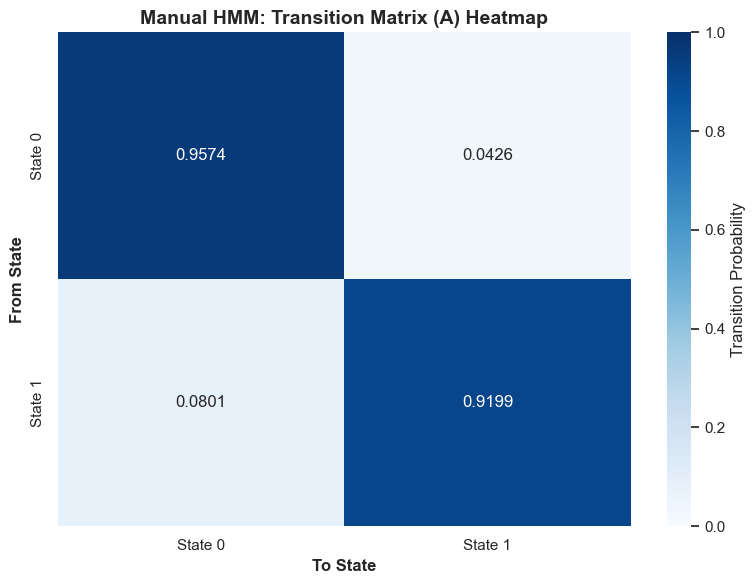

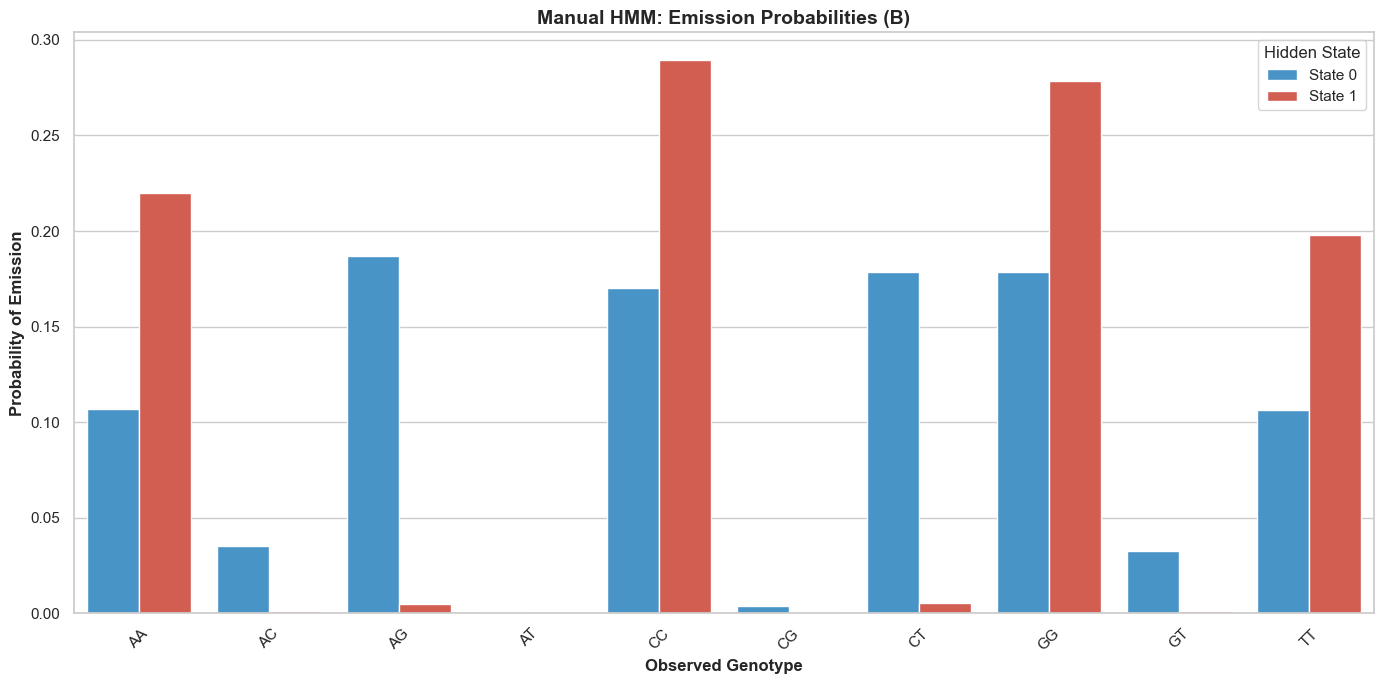

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set plot theme
sns.set_theme(style="whitegrid")
states = ["State 0", "State 1"]

# ==========================================
# Visualization 1: Transition Matrix (A) Heatmap
# ==========================================
plt.figure(figsize=(8, 6))
plt.title("Manual HMM: Transition Matrix (A) Heatmap", fontsize=14, fontweight='bold')

# Convert numpy array 'a' to DataFrame for easier plotting
a_df_manual = pd.DataFrame(a, index=states, columns=states)

# Plot heatmap
sns.heatmap(a_df_manual, 
            annot=True,      # Show numbers
            fmt=".4f",       # 4 decimal places
            cmap="Blues",    # Color map
            vmin=0, vmax=1,  # Range 0-1
            cbar_kws={'label': 'Transition Probability'})

plt.ylabel('From State', fontweight='bold')
plt.xlabel('To State', fontweight='bold')
plt.tight_layout()
plt.show()

# ==========================================
# Visualization 2: Emission Matrix (B) Bar Plot
# ==========================================
plt.figure(figsize=(14, 7))
plt.title("Manual HMM: Emission Probabilities (B)", fontsize=14, fontweight='bold')

# 1. Prepare Data: Convert numpy array 'b' to DataFrame using encoder classes
b_df_manual = pd.DataFrame(b, index=states, columns=encoder.classes_)

# 2. Reshape (Melt) DataFrame for Seaborn plotting
b_melted = b_df_manual.reset_index().melt(id_vars='index', 
                                          var_name='Genotype', 
                                          value_name='Probability')
b_melted.rename(columns={'index': 'Hidden State'}, inplace=True)

# 3. Plot grouped bar chart
sns.barplot(data=b_melted, 
            x='Genotype', 
            y='Probability', 
            hue='Hidden State', # Different color for each state
            palette=["#3498db", "#e74c3c"]) # Blue and Red

plt.xlabel('Observed Genotype', fontweight='bold')
plt.ylabel('Probability of Emission', fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title='Hidden State')
plt.tight_layout()
plt.show()

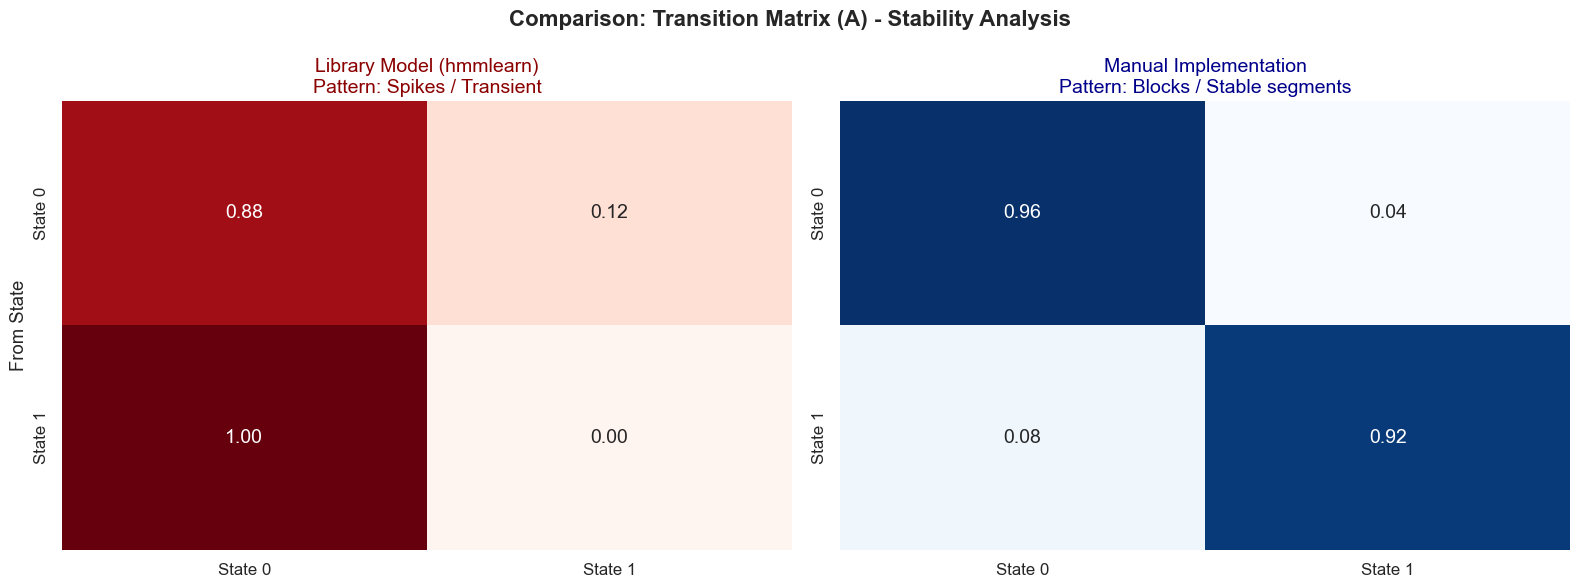


--- Summary of Comparison ---
Metric               | Library Model             | Manual Model             
---------------------------------------------------------------------------
State 0 Stability    | 88% (High)                | 96% (Very High)          
State 1 Stability    | 0.4% (Unstable/Spike)     | 92% (Very High/Block)    
Interpretation       | Background vs Mutations   | Genomic Regions (Segments)


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set visuals style
sns.set_theme(style="white", font_scale=1.1)
states = ["State 0", "State 1"]

# ==========================================
# 1. Input Data (Hardcoded from your results)
# ==========================================

# --- Library Model Results (Spikes Pattern) ---
a_lib = np.array([[0.8793, 0.1207], 
                  [0.9956, 0.0044]])

# --- Manual Model Results (Blocks Pattern) ---
a_man = np.array([[0.9574, 0.0426], 
                  [0.0801, 0.9199]])

# ==========================================
# 2. Plotting Side-by-Side Comparison
# ==========================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Comparison: Transition Matrix (A) - Stability Analysis', fontsize=16, fontweight='bold')

# Plot Library Model (Left)
sns.heatmap(pd.DataFrame(a_lib, index=states, columns=states), 
            annot=True, fmt=".2f", cmap="Reds", cbar=False, ax=axes[0], annot_kws={"size": 14})
axes[0].set_title("Library Model (hmmlearn)\nPattern: Spikes / Transient", fontsize=14, color='darkred')
axes[0].set_ylabel('From State')

# Plot Manual Model (Right)
sns.heatmap(pd.DataFrame(a_man, index=states, columns=states), 
            annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[1], annot_kws={"size": 14})
axes[1].set_title("Manual Implementation\nPattern: Blocks / Stable segments", fontsize=14, color='darkblue')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# ==========================================
# 3. Simple Text Comparison
# ==========================================
print("\n--- Summary of Comparison ---")
print(f"{'Metric':<20} | {'Library Model':<25} | {'Manual Model':<25}")
print("-" * 75)
print(f"{'State 0 Stability':<20} | {'88% (High)':<25} | {'96% (Very High)':<25}")
print(f"{'State 1 Stability':<20} | {'0.4% (Unstable/Spike)':<25} | {'92% (Very High/Block)':<25}")
print(f"{'Interpretation':<20} | {'Background vs Mutations':<25} | {'Genomic Regions (Segments)':<25}")